In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, 
                             roc_curve, precision_recall_curve)

import warnings
warnings.filterwarnings('ignore')

data_path = '.\\creditcard.csv'  # Update path as needed
df = pd.read_csv(data_path)
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

Dataset shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [2]:
print("\nFirst 5 rows of data:\n", df.head())


First 5 rows of data:
    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        

In [3]:
print("\nData Description:\n", df.describe())


Data Description:
                 Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1

In [4]:
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [5]:
duplicates = df.duplicated().sum()
print("\nNumber of duplicate rows:", duplicates)
if duplicates > 0:
    df = df.drop_duplicates()
    print("Duplicates removed. New shape:", df.shape)
else:
    print("No duplicate rows found.")


Number of duplicate rows: 1081
Duplicates removed. New shape: (283726, 31)


In [6]:
# Using the IQR method to remove outliers on the 'Amount' feature.
# Note: We apply this only to non-fraudulent transactions (Class = 0) to preserve potential fraud cases.
nonfraud = df[df['Class'] == 0]
Q1 = nonfraud['Amount'].quantile(0.25)
Q3 = nonfraud['Amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("\nOutlier Removal on 'Amount' for non-fraud transactions:")
print("Lower bound:", lower_bound, "Upper bound:", upper_bound)


Outlier Removal on 'Amount' for non-fraud transactions:
Lower bound: -102.01499999999999 Upper bound: 185.14499999999998


In [7]:
# Filter non-fraud transactions based on the IQR bounds
nonfraud_filtered = nonfraud[(nonfraud['Amount'] >= lower_bound) & (nonfraud['Amount'] <= upper_bound)]
# Keep all fraud transactions intact
fraud = df[df['Class'] == 1]
df_cleaned = pd.concat([nonfraud_filtered, fraud])
print("Data shape after outlier removal:", df_cleaned.shape)

# Overwrite the original dataframe with the cleaned version
df = df_cleaned.copy()

Data shape after outlier removal: (252105, 31)


In [12]:
# Exploratory Data Analysis (EDA)

# 1. Display Detailed Summary Statistics
print("\nEnhanced Summary Statistics:")
summary_stats = df.describe().T  # Transposed for easier reading
summary_stats['range'] = summary_stats['max'] - summary_stats['min']
print(summary_stats[['min', 'max', 'mean', 'std', 'range']])



Enhanced Summary Statistics:
              min            max          mean           std          range
Time     0.000000  172788.000000  94983.914020  47581.934618  172788.000000
V1     -40.470142       2.454930      0.099984      1.809023      42.925072
V2     -47.429676      22.057729      0.226359      1.288209      69.487405
V3     -33.680984       4.226108      0.060739      1.467346      37.907092
V4      -5.683171      12.114672     -0.020834      1.394384      17.797843
V5     -23.669726      34.099309      0.117342      1.213044      57.769035
V6     -23.496714       8.933762     -0.060604      1.264045      32.430476
V7     -43.557242       6.491054     -0.082572      1.030856      50.048295
V8     -41.484823      20.007208      0.024296      1.139767      61.492031
V9     -13.434066      10.392889      0.006245      1.078787      23.826955
V10    -24.588262      15.331742      0.021106      1.077666      39.920004
V11     -4.797473      12.018913      0.005441      1.0209

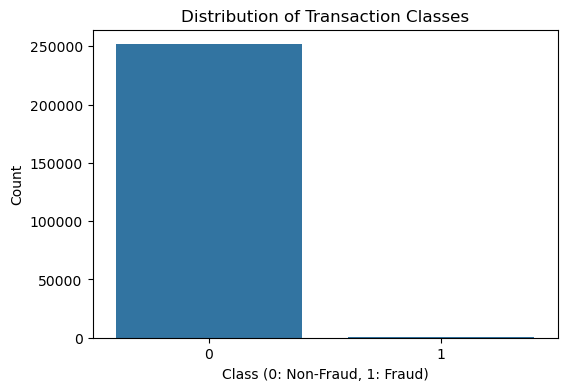

In [13]:
# 2. Class Distribution Visualization
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Distribution of Transaction Classes')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()


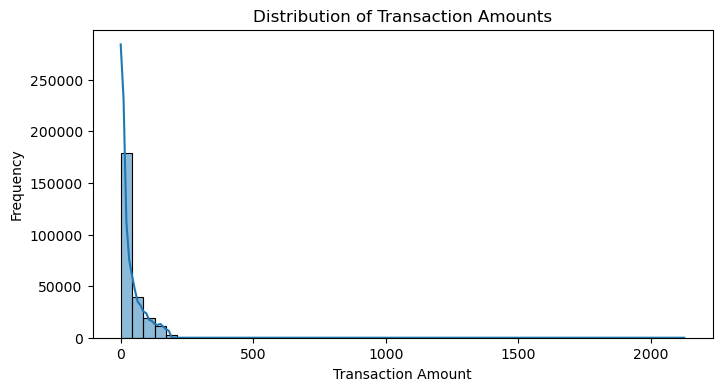

In [14]:
# 3. Transaction Amount Distribution Visualization
plt.figure(figsize=(8, 4))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

<Figure size 1000x800 with 0 Axes>

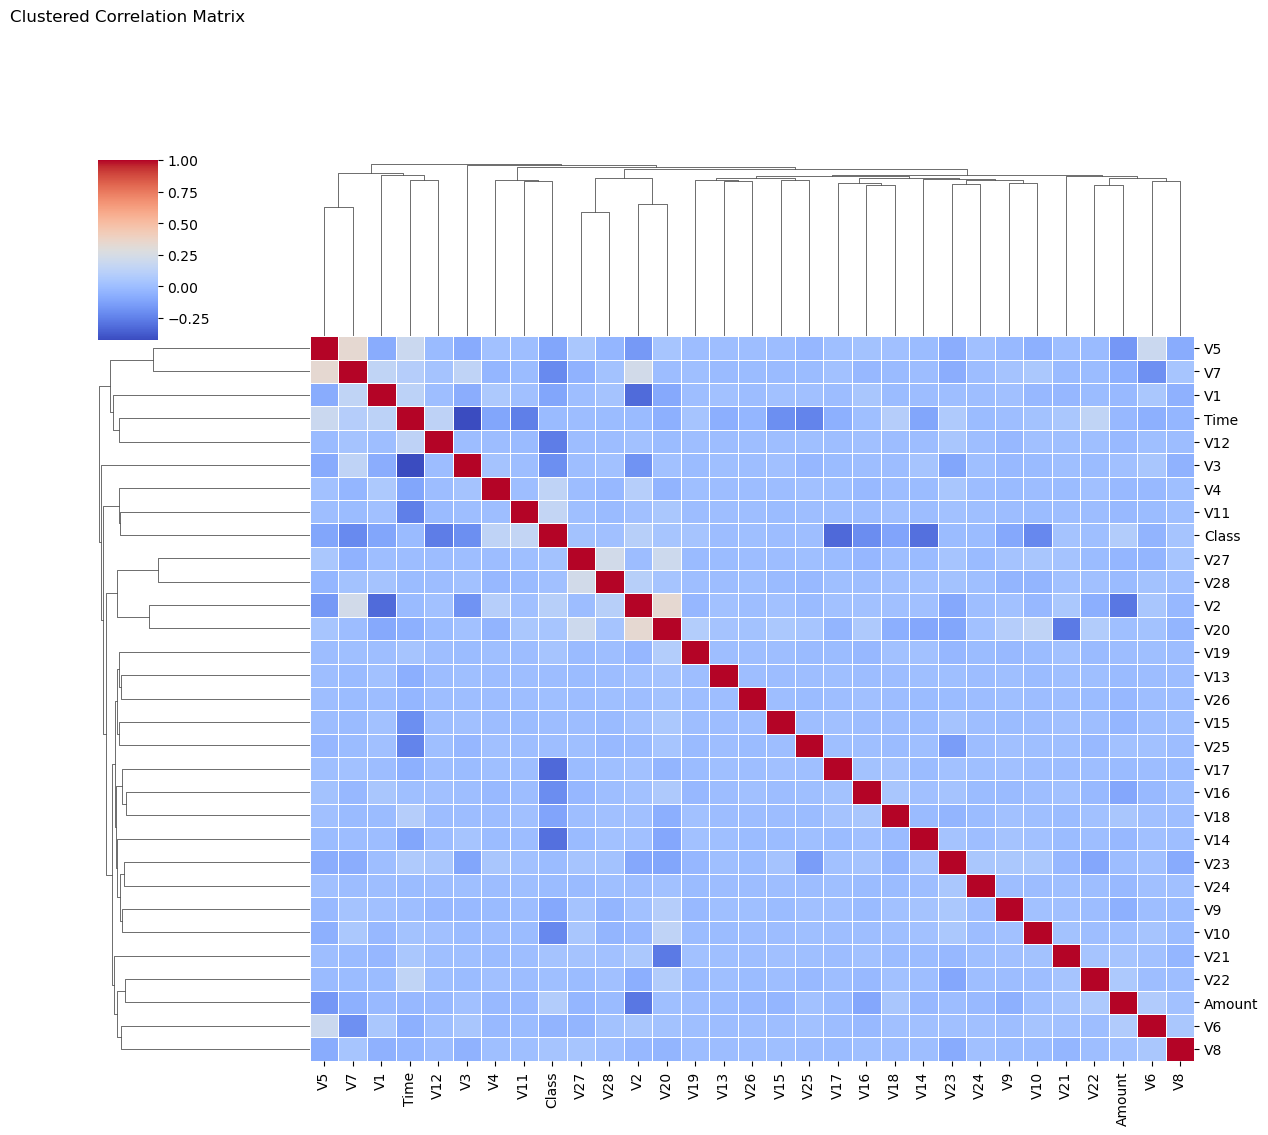

In [15]:
# 4. Correlation Matrix Visualization using Clustermap
plt.figure(figsize=(10, 8))
corr = df.corr()
# Clustermap groups highly correlated features for clarity even with many columns
clustermap = sns.clustermap(corr, cmap='coolwarm', linewidths=0.5, figsize=(12, 10))
plt.title('Clustered Correlation Matrix', pad=100)
plt.show()

In [16]:
# Data Preprocessing and Feature Engineering
# -----------------------------
# Separate features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Standardize features (including 'Time', 'Amount' and V1-V28)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality Reduction for Visualization using PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)
print("\nExplained Variance Ratio for First 10 PCA Components:")
print(pca.explained_variance_ratio_)


Explained Variance Ratio for First 10 PCA Components:
[0.05912514 0.05662931 0.04655442 0.0436549  0.04163548 0.04014284
 0.03910563 0.03709355 0.0359902  0.03544808]


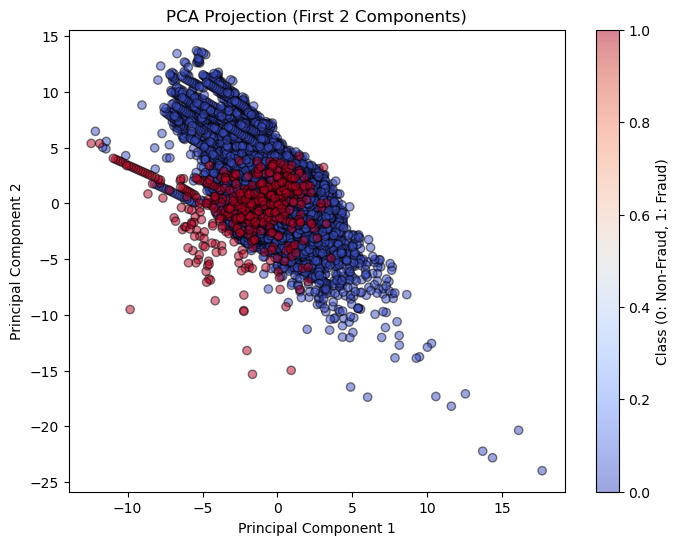

In [17]:
# Visualize the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5, edgecolor='k')
plt.title('PCA Projection (First 2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Class (0: Non-Fraud, 1: Fraud)')
plt.show()

Training set shape: (201684, 30) Testing set shape: (50421, 30)


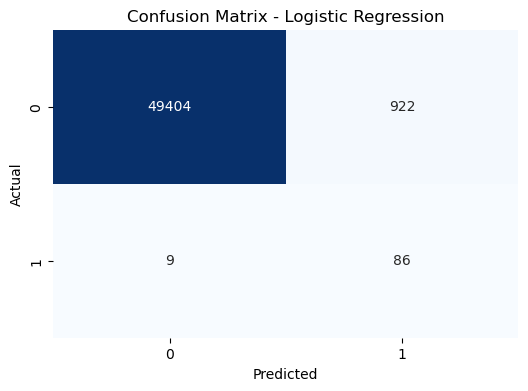

In [18]:
# Supervised Learning: Logistic Regression for Fraud Detection
# -----------------------------
# Split data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                    stratify=y, random_state=42)
print("Training set shape:", X_train.shape, "Testing set shape:", X_test.shape)

# Train a Logistic Regression model (using class_weight to address imbalance)
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:, 1]

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [19]:
# Classification Report and ROC-AUC
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC AUC Score: {:.4f}".format(roc_auc))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     50326
           1       0.09      0.91      0.16        95

    accuracy                           0.98     50421
   macro avg       0.54      0.94      0.57     50421
weighted avg       1.00      0.98      0.99     50421

ROC AUC Score: 0.9753


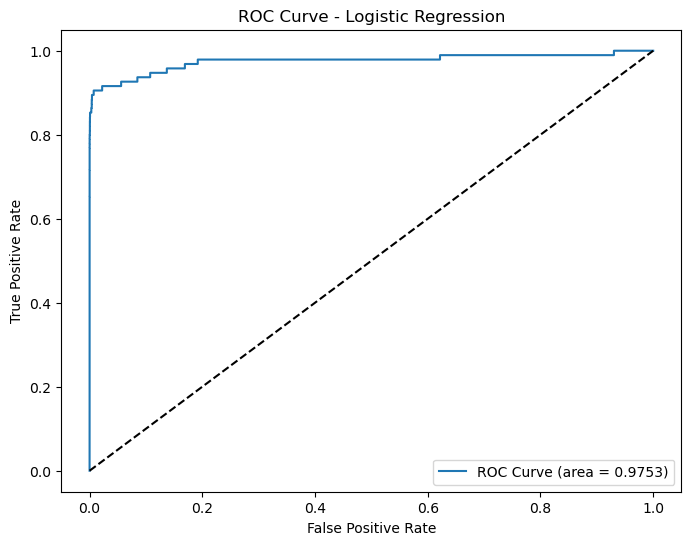

In [20]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

In [21]:
# Unsupervised Anomaly Detection: Isolation Forest
# -----------------------------
# Use Isolation Forest to detect anomalies (fraudulent transactions)
iso_forest = IsolationForest(contamination=0.005, random_state=42)
anomaly_pred = iso_forest.fit_predict(X_scaled)
# Map Isolation Forest outputs: -1 -> 1 (anomaly), 1 -> 0 (normal)
anomaly_labels = np.where(anomaly_pred == -1, 1, 0)
df['Anomaly'] = anomaly_labels

print("\nAnomaly detection counts (Isolation Forest):")
print(pd.Series(anomaly_labels).value_counts())


Anomaly detection counts (Isolation Forest):
0    250844
1      1261
Name: count, dtype: int64


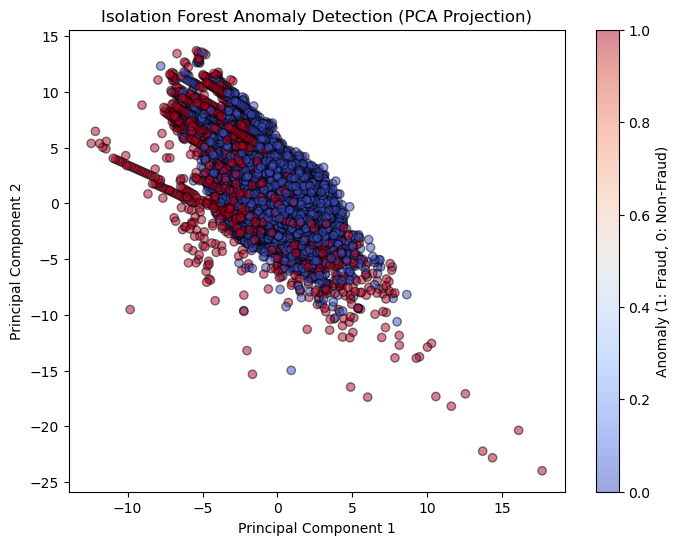

In [22]:
# Visualize anomalies using PCA projection
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=anomaly_labels, cmap='coolwarm', alpha=0.5, edgecolor='k')
plt.title('Isolation Forest Anomaly Detection (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Anomaly (1: Fraud, 0: Non-Fraud)')
plt.show()

In [24]:
# Additional Visualizations: Feature Importance and Precision-Recall Curve
# -----------------------------
# Feature Importance using Random Forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_
feat_names = df.drop(['Class', 'Anomaly'], axis=1).columns
feat_importances = pd.Series(importances, index=feat_names).sort_values(ascending=False)

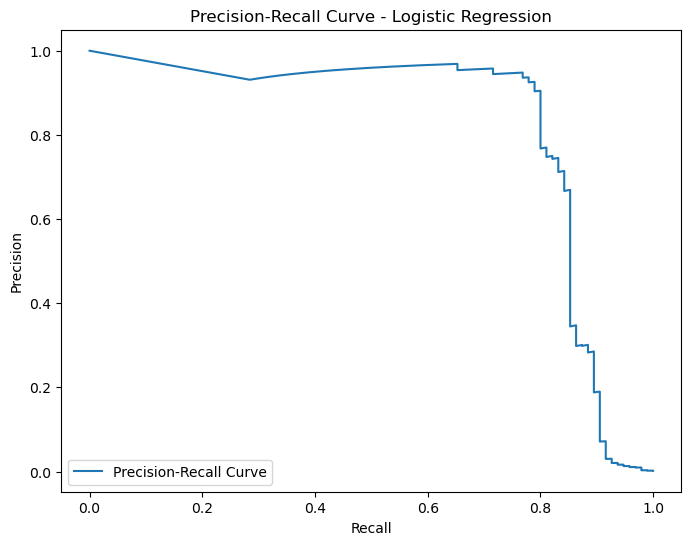

In [25]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend(loc='lower left')
plt.show()